In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np
from dtw import dtw
import warnings
warnings.filterwarnings("ignore") 
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_parquet("~/downloads/steam_hw_survey.parquet")

df.shape


(262470, 5)

This notebook documents the exploration of optimizing three autoregression models through an understanding and tweaking of approaches and parameters. Trends for Linux, MacOS, and Windows are independently forecasted to an optimally low RMSE and visually satisfactory forecasting trend.

In [2]:
def compute_rmse(train, test, order, seasonal_order, enforce_stationarity=True, enforce_invertibility=True):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=enforce_stationarity,
                    enforce_invertibility=enforce_invertibility)
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=len(test)).predicted_mean
    forecast.index = test.index
    rmse = np.sqrt(mean_squared_error(test, forecast))
    return rmse

def plot_forecast(ts, name, order, seasonal_order, enforce_stationarity=True, enforce_invertibility=True):
    train = ts[:'2020']
    test = ts['2021':]
    
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=enforce_stationarity,
                    enforce_invertibility=enforce_invertibility)
    results = model.fit(disp=False)
    
    forecast = results.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train, label="Training Data")
    plt.plot(test.index, test, color="green", label="Actual (2021)")
    plt.plot(test.index, forecast_mean, color="red", linestyle="--", label="Forecast")
    plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f"{name} SARIMA Forecast\nOrder: {order}, Seasonal: {seasonal_order}, RMSE: {rmse:.4f}")
    plt.xlabel("Date")
    plt.ylabel("Market Share (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    return results


This dataset aggregates OS data from 2014 (The first year that steam started collecting data on Linux ) to December 2021. Market share by month is provided by the category "OS version (total)". The goal here is to get a sense of the data and then push it through three autoregression models, one for each platform. Then I plan to evaluate performance via RMSE.

In [3]:
df.isnull().sum()

index       0
perc        0
category    0
date        0
platform    0
dtype: int64

In [4]:
df.head()

,index,perc,category,date,platform
0,Unspecified,10.01,Network Speed,2004-04-01,pc
1,14.4 Kbps,0.10,Network Speed,2004-04-01,pc
2,28.8 Kbps,0.18,Network Speed,2004-04-01,pc
3,33.6 Kbps,0.13,Network Speed,2004-04-01,pc
4,56.0 Kbps,3.38,Network Speed,2004-04-01,pc


In [5]:
df_total_os = df[df['category'] == 'OS Version (total)'].copy()

df_os_share = df_total_os.pivot_table(
    index='date',
    columns='index',     # OS label: Windows, OSX, Linux
    values='perc',
    aggfunc='sum'
).fillna(method='ffill')

In [6]:
df_os_share.head()

index,Linux,OSX,Windows
date,,,
2014-02-01,0.86,3.47,94.93
2014-03-01,1.30,3.42,95.17
2014-04-01,1.20,3.54,95.12
2014-05-01,1.26,3.36,95.25
2014-06-01,1.10,3.30,95.50


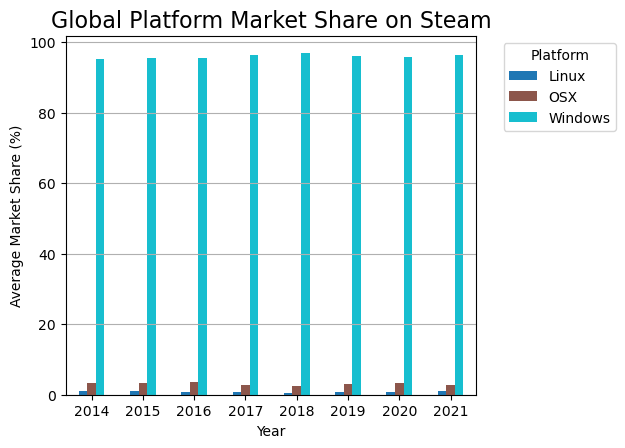

In [7]:


df_yearly = df_os_share.resample("Y").mean()

df_yearly.index = df_yearly.index.year 
ax = df_yearly.plot(
    kind="bar",
    stacked=False,
    colormap="tab10"
)



plt.title("Global Platform Market Share on Steam", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Average Market Share (%)")
plt.legend(title="Platform", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

In [8]:
df_yearly

index,Linux,OSX,Windows
date,,,
2014,1.136364,3.408182,95.279091
2015,0.975000,3.321667,95.600833
2016,0.879167,3.496667,95.509167
2017,0.664167,2.802500,96.447500
2018,0.525000,2.471667,96.953333
2019,0.808333,3.090000,96.100000
2020,0.870000,3.400000,95.730000
2021,0.942500,2.785833,96.272500


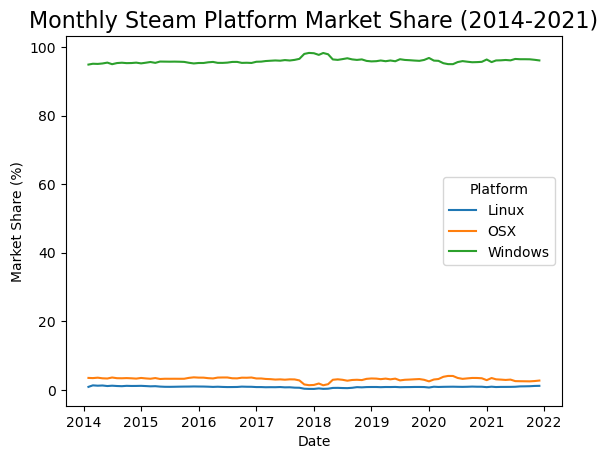

In [9]:


for platform in df_os_share.columns:
    plt.plot(df_os_share.index, df_os_share[platform], label=platform)

plt.title('Monthly Steam Platform Market Share (2014-2021)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Market Share (%)')
plt.legend(title='Platform')
plt.show()


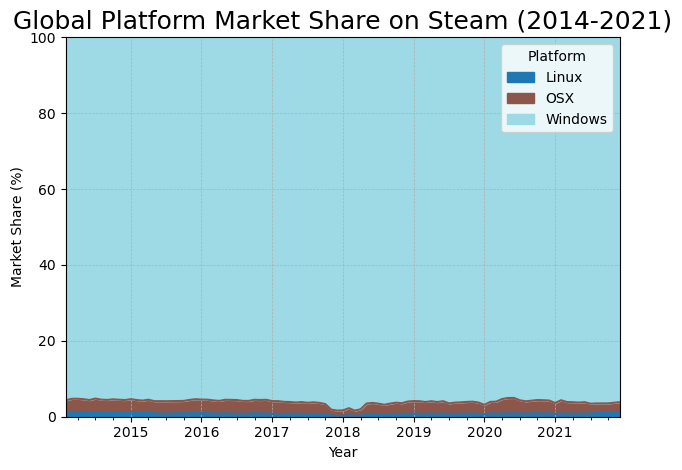

In [10]:
df_os_share.plot.area(
    colormap="tab20",
)

plt.title("Global Platform Market Share on Steam (2014-2021)", fontsize=18)
plt.xlabel("Year")
plt.ylabel("Market Share (%)")
plt.ylim(0, 100)
plt.legend(title="Platform")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


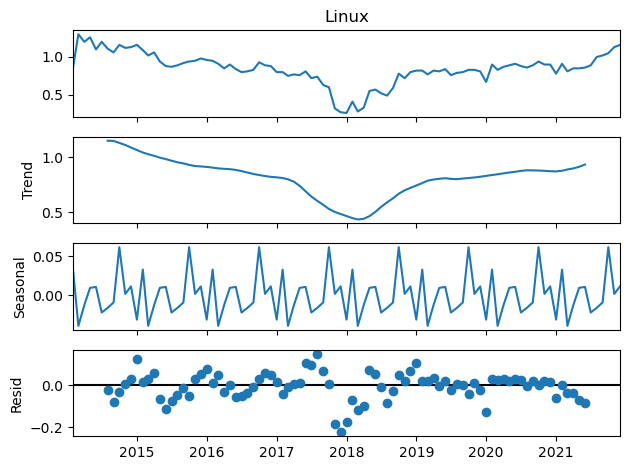

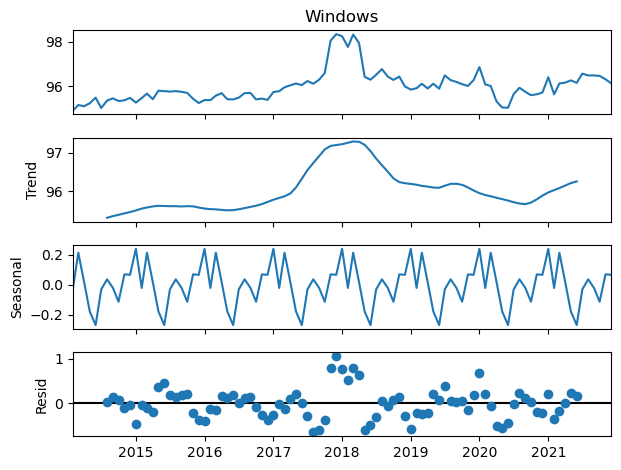

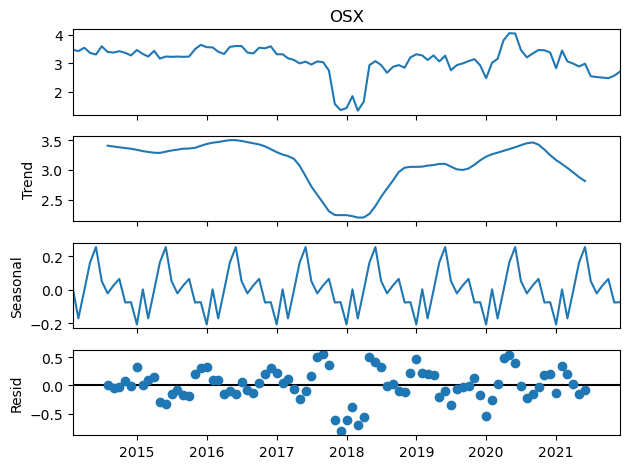

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = df_os_share["Linux"] 

decomposition = seasonal_decompose(ts, model='additive', period=12)
decomposition.plot()
plt.show()

ts = df_os_share["Windows"] 

decomposition = seasonal_decompose(ts, model='additive', period=12)
decomposition.plot()
plt.show()

ts = df_os_share["OSX"] 

decomposition = seasonal_decompose(ts, model='additive', period=12)
decomposition.plot()
plt.show()



This plot from statsmodels is a very good indicator that the data is seasonal, which calls for an autoregression model that is suited to interpret seasonal data. 

After filtering for OS share data, then pivoting to get 1 column per OS, we can now prep for the model. I believe SARIMA, or Seasonal AutoRegressive Integrated Moving Average, will be the optimal model to use in this context because of its ability to work with seasonal time-series data.

In [12]:
df_os_share

index,Linux,OSX,Windows
date,,,
2014-02-01,0.86,3.47,94.93
2014-03-01,1.30,3.42,95.17
2014-04-01,1.20,3.54,95.12
2014-05-01,1.26,3.36,95.25
2014-06-01,1.10,3.30,95.50
...,...,...,...
2021-08-01,1.00,2.51,96.49
2021-09-01,1.02,2.49,96.49
2021-10-01,1.05,2.47,96.47


--- Training and Plotting ARIMA Models ---


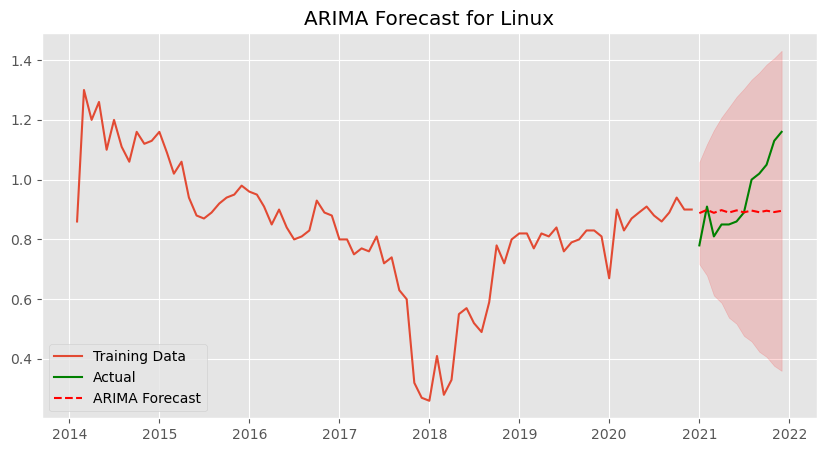

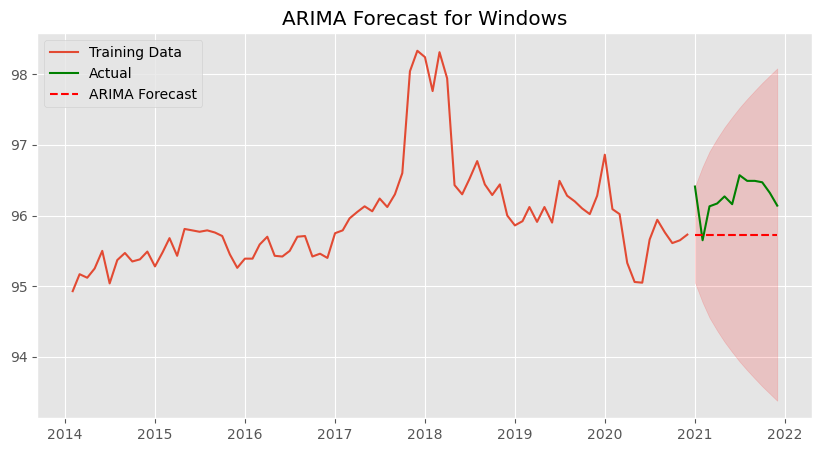

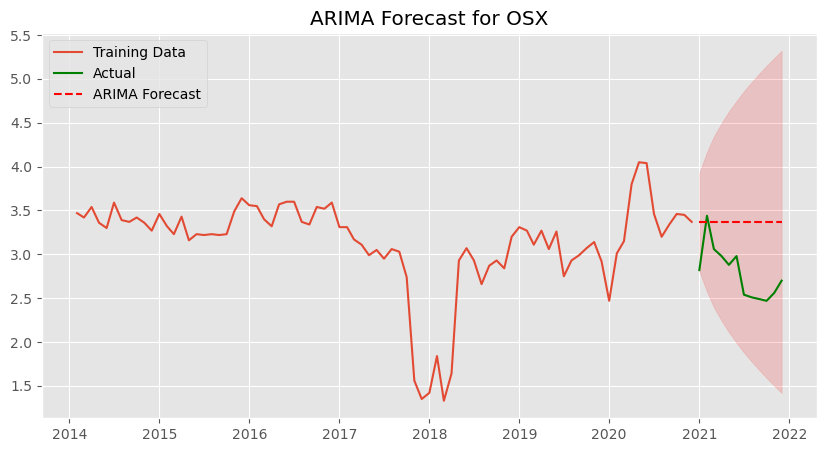

In [13]:

nobs = 12
df_train_orig = df_os_share[0:-nobs]
df_test_orig = df_os_share[-nobs:]

# --- 2. ARIMA Models and Visualizations ---
print("--- Training and Plotting ARIMA Models ---")
arima_forecasts = {}
for platform in ['Linux', 'Windows', 'OSX']:
    # Fit a unique ARIMA model for each platform
    ts = df_os_share[platform].dropna()
    train_arima = ts[:'2020-12-31']
    test_arima = ts['2021-01-01':]
    
    arima_model = pm.auto_arima(train_arima, start_p=1, start_q=1, d=1, seasonal=False)
    fc, conf_int = arima_model.predict(n_periods=nobs, return_conf_int=True)
    arima_forecasts[platform] = pd.Series(fc, index=test_arima.index)

    plt.style.use('ggplot')
    plt.figure(figsize=(10, 5))
    plt.plot(train_arima, label='Training Data')
    plt.plot(test_arima, label='Actual', color='green')
    plt.plot(arima_forecasts[platform], label='ARIMA Forecast', color='red', linestyle='--')
    plt.fill_between(arima_forecasts[platform].index, conf_int[:, 0], conf_int[:, 1], color='red', alpha=.15)
    plt.title(f'ARIMA Forecast for {platform}')
    plt.legend()
    plt.show()



In [14]:


linux_ts = df_os_share["Linux"]
train = linux_ts[:'2020']
test = linux_ts['2021':]

model_arima = SARIMAX(train, order=(1, 1, 1))
results_arima = model_arima.fit()

forecast_arima = results_arima.get_forecast(steps=len(test))
forecast_mean_arima = forecast_arima.predicted_mean

rmse_arima = np.sqrt(mean_squared_error(test, forecast_mean_arima))
print(f"LINUX ARIMA (1,1,1) RMSE: {rmse_arima:.4f}")



LINUX ARIMA (1,1,1) RMSE: 0.1294


The protype is designed to automatically detect and utilize seasonality, but in our case discards seasonality as the threshold for detection was not met / detected. In the model row, it has one set of parentheses, two would indicate that it has detected seasonality. This makes the model ARIMA definitionally. 

NOT HAPPY with this models performance, very weak and underfit. The RMSE is more than 10% of the value range, which is big for this kind of market share data. RMSE was chosen to be very sensitive to deviations from the trend. 

I have the option of pivoting toward a compositional model like VAR, but models like VAR are not able to capture each platform's specific seasonal memory. For example, Linux behaves in a very different way to OSX and Windows, and to consolidate all into one model would mean a loss in this detail. Then, I will confirm seasonality and force it into the model, making it a SARIMA model.

# LINUX RESIDUALS FOR ARIMA AND SARIMA

ARIMA or no seasonality

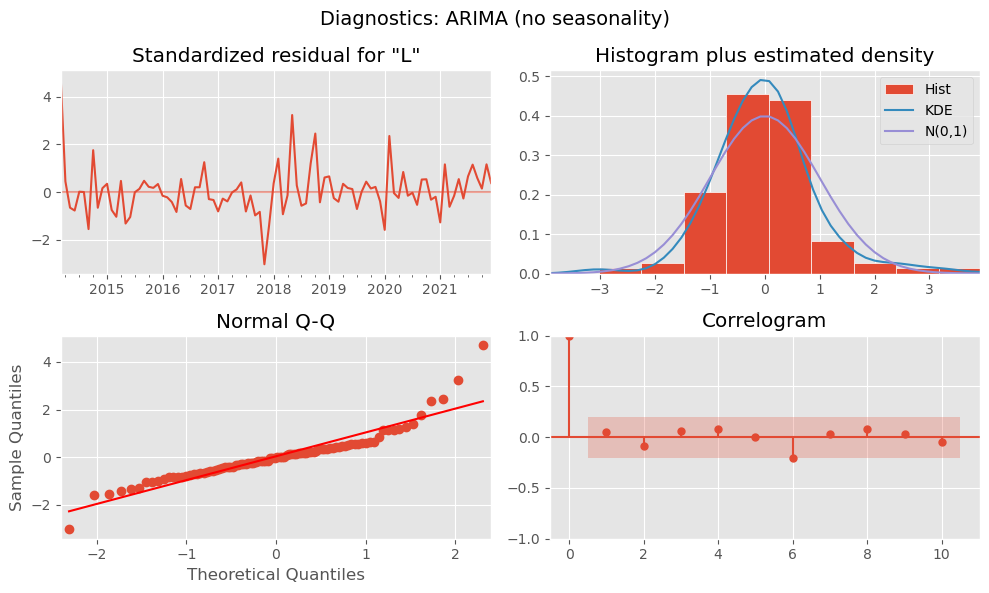

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

model_no_season = SARIMAX(df_os_share["Linux"], order=(1, 1, 1))  # No seasonal_order here
results_no_season = model_no_season.fit()

results_no_season.plot_diagnostics(figsize=(10, 6))
plt.suptitle("Diagnostics: ARIMA (no seasonality)", fontsize=14)
plt.tight_layout()
plt.show()


SARIMA or seasonality

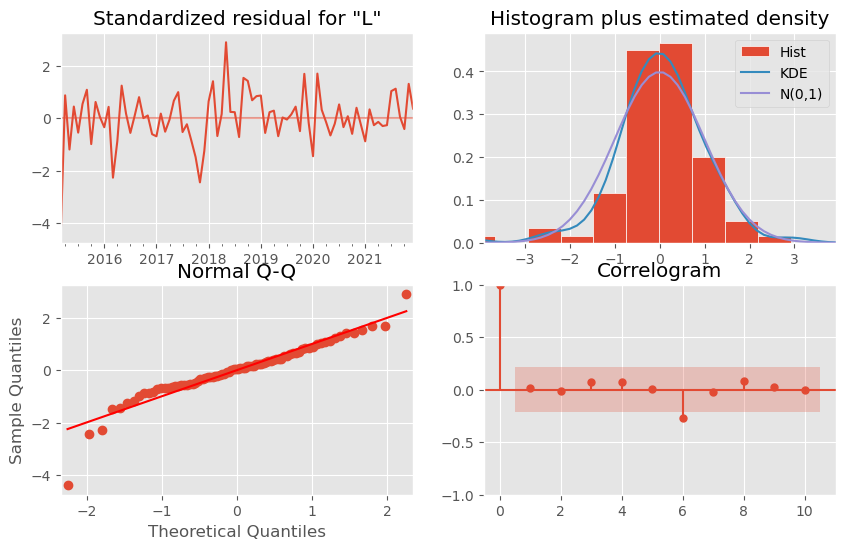

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX



model = SARIMAX(df_os_share["Linux"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()
results.plot_diagnostics(figsize=(10, 6))
plt.show()


Here we are confirming that the model fits when introducing the seasonality component. It is trained on the entire model, but only uses its learned rules and structure to make internal predictions. The result is how well the model preforms against the actual data. We notice a few things. 

1. The swings in the standardized residuals for ARIMA are nearly double those of SARIMA, evidenced by the Y axis going from a max of 2 to 4 to accomodate the increased swings.

2. The histogram shows how the orange line (smoothed estimate of the model's residual distribution) is much better aligned with the green line (normal distribution) in the SARIMA plot. 

3. ARIMA has heavier tails on the Normal Q-Q plot. Larger residuals don't follow the red line, while SARIMA is much closer.

4. The correlogram plot is a little bit suspect. The autocorrelation at lag 6 is not in the shaded region in either model, which prompted experimentation with different parameters for seasonality.


=== (1,1,1,12) ===


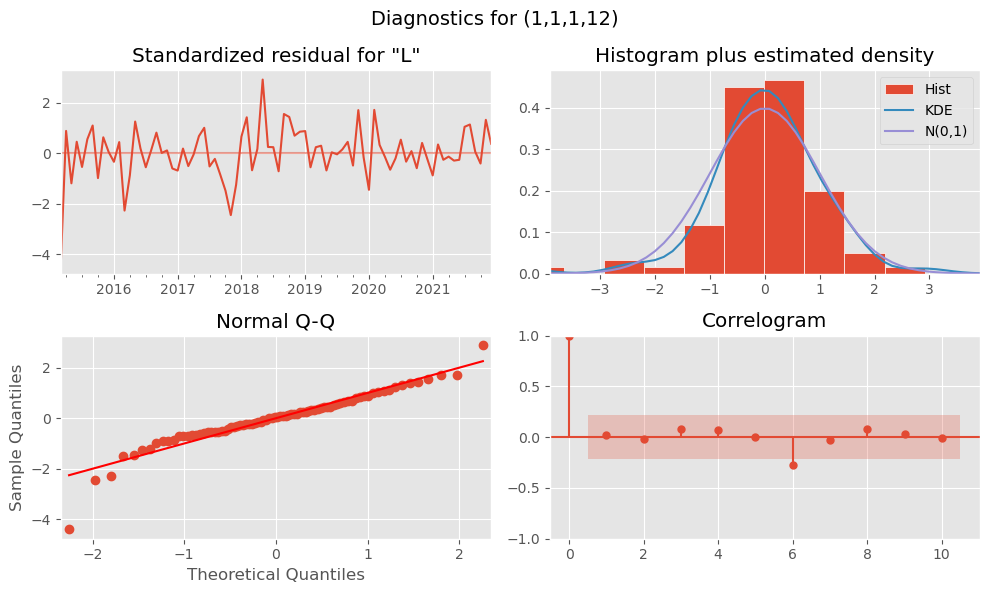


=== (1,0,1,12) ===


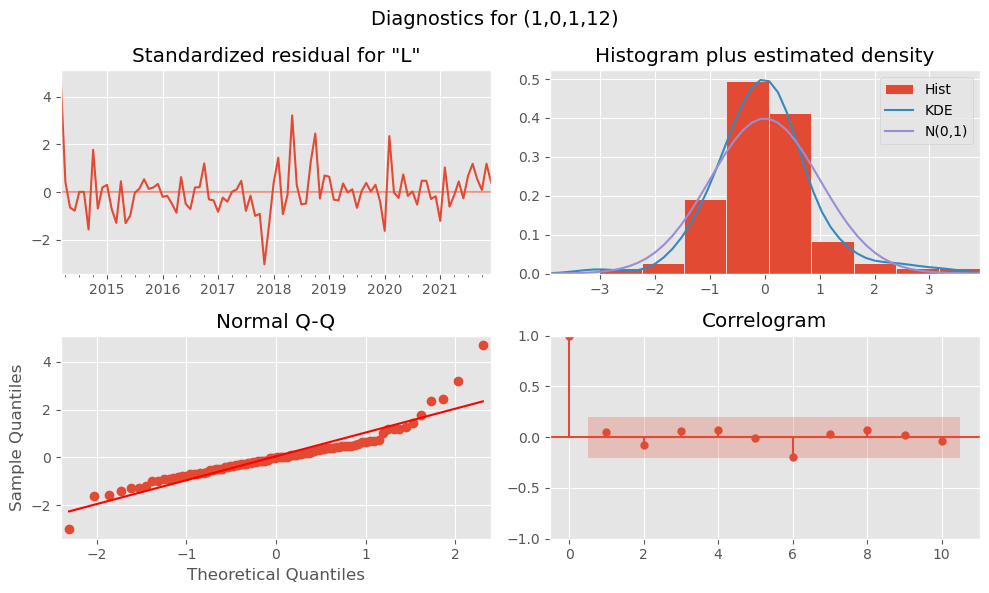


=== (0,1,1,12) ===


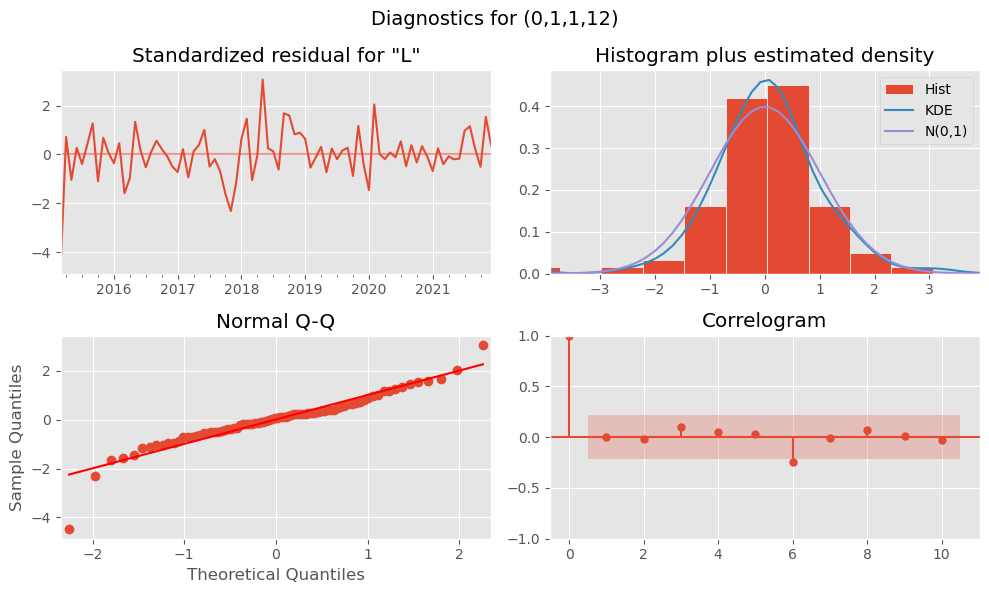


===  (1,1,0,12) ===


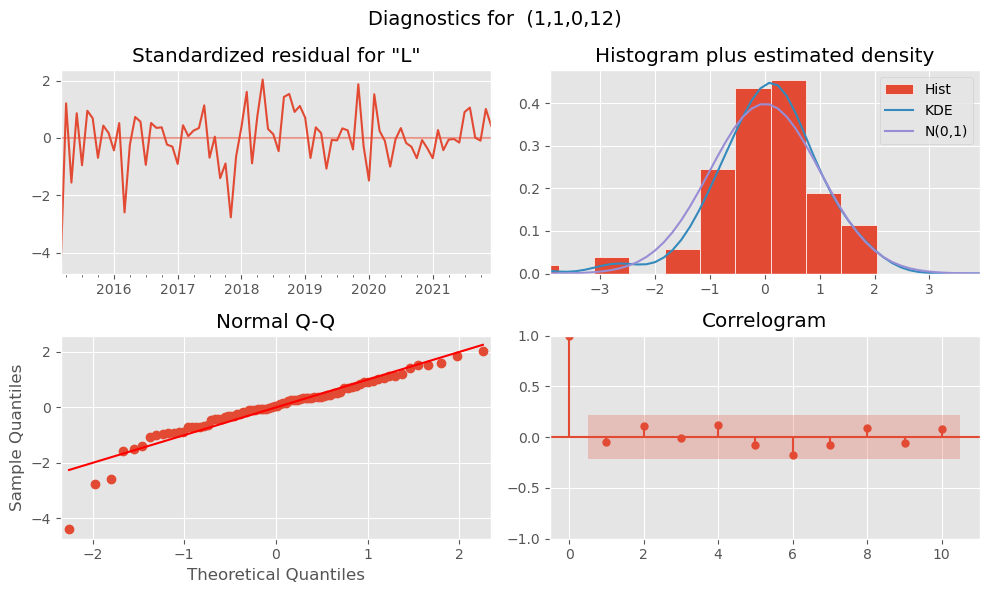


===  (0,1,0,12) ===


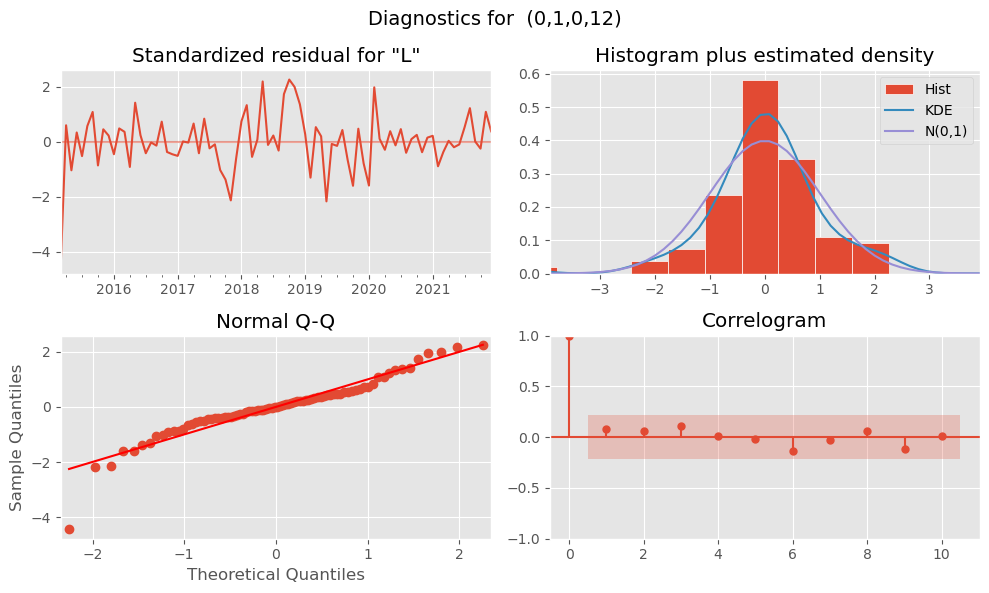

In [17]:


seasonal_configs = {
    "(1,1,1,12)": (1, 1, 1, 12),
    "(1,0,1,12)": (1, 0, 1, 12),
    "(0,1,1,12)": (0, 1, 1, 12),
    " (1,1,0,12)": (1, 1, 0, 12),
    " (0,1,0,12)": (0, 1, 0, 12),
}

for label, s_order in seasonal_configs.items():
    print(f"\n=== {label} ===")
    model = SARIMAX(df_os_share["Linux"], order=(1, 1, 1), seasonal_order=s_order)
    results = model.fit(disp=False)
        
    results.plot_diagnostics(figsize=(10, 6))
    plt.suptitle(f"Diagnostics for {label}", fontsize=14)
    plt.tight_layout()
    plt.show()


The best models here for Linux according to only the Correlogram are (0,1,0,12) and (1,1,0,12). These, along with the original (1,1,1,12) parameters are plotted below.

# PLOTS AND RMSE FOR THE BEST THREE DIFFERENT SEASONALITY PARAMETERS

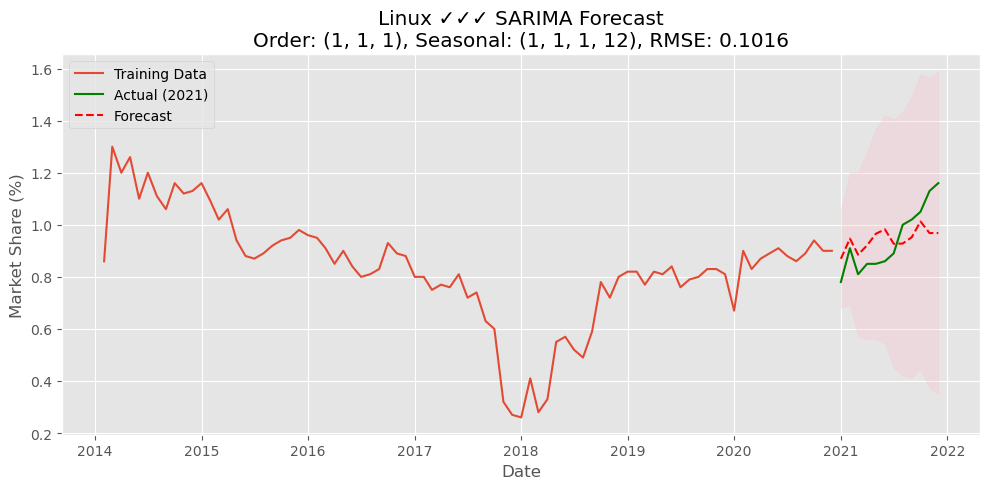

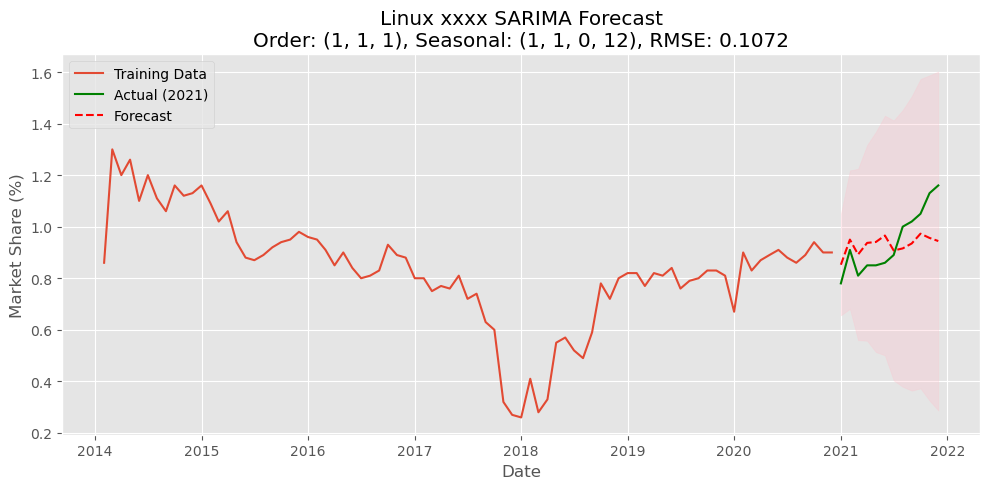

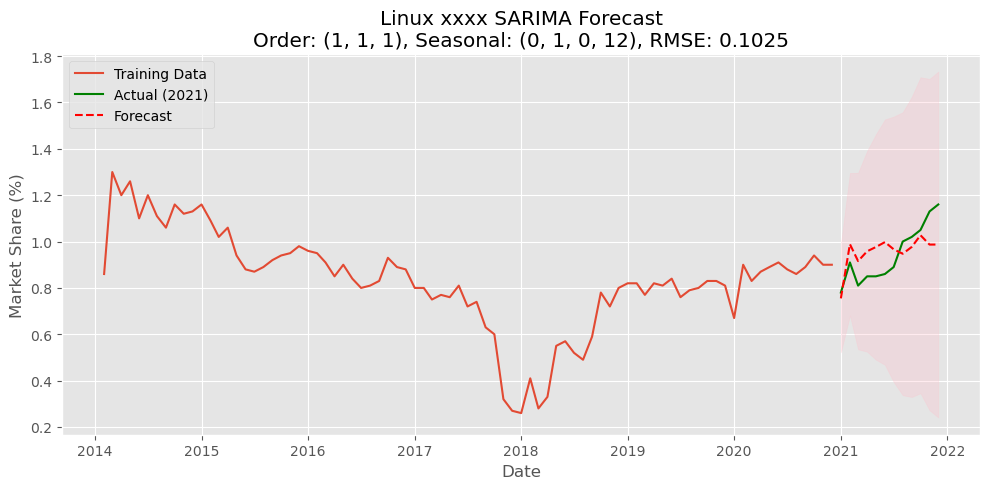

In [18]:
#original seasonality parameters

plot_forecast(linux_ts, "Linux ✓✓✓", (1,1,1), (1,1,1,12))
plot_forecast(linux_ts, "Linux xxxx", (1,1,1), (1,1,0,12))
plot_forecast(linux_ts, "Linux xxxx", (1,1,1), (0,1,0,12))


Visual confirmation of the SARIMA trend and lower RMSE confirms that the SARIMA model fares best with our original seasonality parameters of (1,1,1,12). Further testing with orders other than (1,1,1) were unsuccessful, increased RMSE and flattened forecast. Thus, the best linux model seems to be the default order of (1,1,1) and seasonal order of (1,1,1,12).

We can run a loop to test different seasonality orders for Windows and MacOS

In [19]:

windows_ts = df_os_share["Windows"]
osx_ts = df_os_share["OSX"]

train_win = windows_ts[:'2020']
test_win = windows_ts['2021':]
train_osx = osx_ts[:'2020']
test_osx = osx_ts['2021':]

#  seasonal orders to test
seasonal_orders = [
    (1, 1, 1, 12),
    (1, 1, 0, 12),
    (0, 1, 1, 12),
    (0, 1, 0, 12),
    (1, 0, 1, 12)
]

results = []

for label, train, test in [
    ("Windows", train_win, test_win),
    ("OSX", train_osx, test_osx)
]:
    for s_order in seasonal_orders:
        try:
            model = SARIMAX(train, order=(1, 0, 1), seasonal_order=s_order)

# WINDOWS AND MAC RESPOND BEST TO 1,0,1 FOR ORDER

            fit = model.fit(disp=False)
            forecast = fit.get_forecast(steps=len(test)).predicted_mean
            forecast.index = test.index
            rmse = np.sqrt(mean_squared_error(test, forecast))
            results.append((label, s_order, rmse))
        except Exception as e:
            results.append((label, s_order, np.nan))

df_results = pd.DataFrame(results, columns=["Series", "Seasonal_Order", "RMSE"])
df_results.sort_values(by=["Series", "RMSE"], inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results


,Series,Seasonal_Order,RMSE
0,OSX,"(1, 1, 1, 12)",0.514426
1,OSX,"(0, 1, 1, 12)",0.539559
2,OSX,"(1, 0, 1, 12)",0.568680
3,OSX,"(1, 1, 0, 12)",0.598024
4,OSX,"(0, 1, 0, 12)",0.879010
5,Windows,"(1, 1, 1, 12)",0.518014
6,Windows,"(0, 1, 1, 12)",0.553314
7,Windows,"(1, 1, 0, 12)",0.566934
8,Windows,"(1, 0, 1, 12)",0.635486
9,Windows,"(0, 1, 0, 12)",0.884149


Gauging off the RMSE scores of the different models, **MacOS** AND **Windows** forecasts perform best under (1,1,1,12) parameters. These are the same seasonality parameters as Linux. The order had to be changed to (1,0,1), with the middle value corresponding to differencing (reducing the fluctuations or seasonality so the model is more stable). Both windows and MacOS have much more stable trends, so differencing proves to be unnecessary and even counter productive. So we set that value to off. For Linux, where the trend has a clearer upward trajectory, differencing helped in reigning that trend in to a stable baseline.

There are two more parameters to play with, and those are stationarity and invertibility. Turning them off (enforce_stationarity=False, enforce_invertibility=False) allows the optimizer to explore a wider parameter space, which can lead to lower RMSE and better predictions. These constraints are left on in our Linux model, as relaxing them resulted in a higher RMSE and a flattened forecast, worsening performance.

In [20]:
#  the best seasonal orders previously determined
best_seasonal_order = {
    "Windows": (1, 1, 1, 12),
    "OSX": (1, 1, 1, 12)
}

# comparison of enforcement flags only
enforce_comparison_results = []

#compare RMSE with and without enforcement
for label, train, test in [
    ("Windows", train_win, test_win),
    ("OSX", train_osx, test_osx)
]:
    for enforce in [(True, True), (False, False)]:
        rmse = compute_rmse(train, test, (1, 0, 1), best_seasonal_order[label], *enforce)
        enforce_comparison_results.append({
            "Series": label,
            "Order": (1, 0, 1),
            "Seasonal_Order": best_seasonal_order[label],
            "Stationarity_Enforced": enforce[0],
            "Invertibility_Enforced": enforce[1],
            "RMSE": rmse
        })

enforce_comparison_df = pd.DataFrame(enforce_comparison_results)
enforce_comparison_df.sort_values(by=["Series", "RMSE"], inplace=True)
enforce_comparison_df.reset_index(drop=True, inplace=True)
enforce_comparison_df


,Series,Order,Seasonal_Order,Stationarity_Enforced,Invertibility_Enforced,RMSE
0,OSX,"(1, 0, 1)","(1, 1, 1, 12)",False,False,0.435617
1,OSX,"(1, 0, 1)","(1, 1, 1, 12)",True,True,0.514426
2,Windows,"(1, 0, 1)","(1, 1, 1, 12)",False,False,0.375858
3,Windows,"(1, 0, 1)","(1, 1, 1, 12)",True,True,0.518014


Turning off enforce_stationarity and enforce_invertibility for the previously best parameters led to significantly lower RMSE for both macOS and Windows

- macOS RMSE dropped from 0.5144 to 0.4356
- Windows RMSE dropped from 0.5180 to 0.3759

The best model for MacOS and Windows then, should have these turned off. 

Now that satisfactory parameters have been chosen for all models, these are the final forecasts and visualizations.

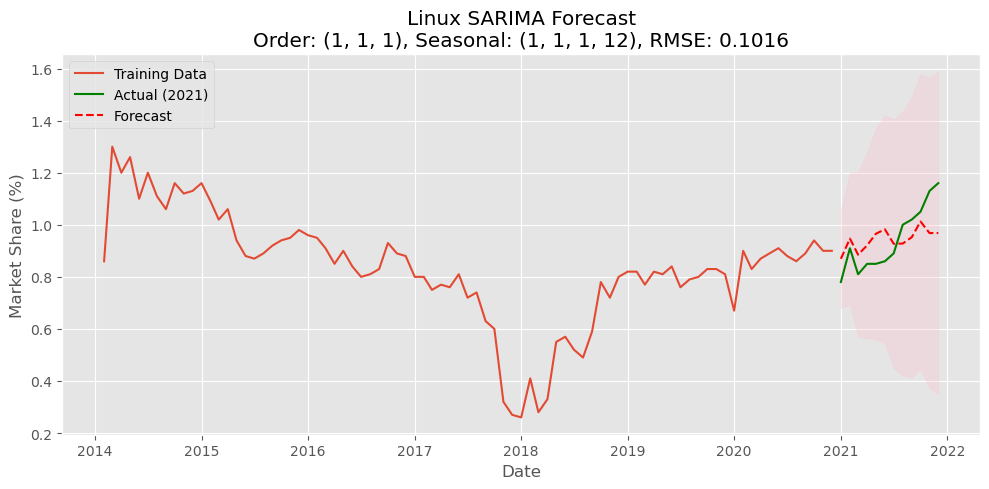

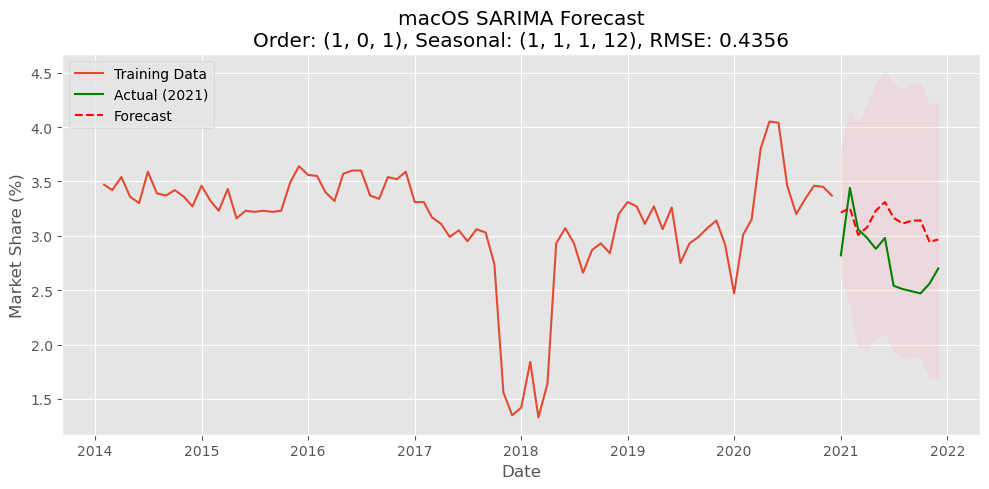

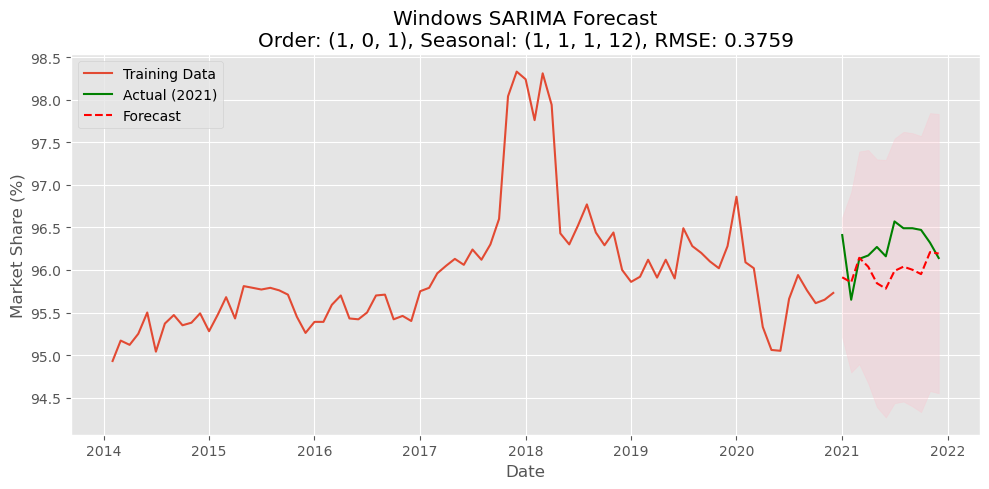

In [21]:

linux_ts = df_os_share["Linux"]
windows_ts = df_os_share["Windows"]
osx_ts = df_os_share["OSX"]




plot_forecast(linux_ts, "Linux", (1,1,1), (1,1,1,12), True, True)
plot_forecast(osx_ts, "macOS", (1,0,1), (1,1,1,12), False, False)
plot_forecast(windows_ts, "Windows", (1,0,1), (1,1,1,12), False, False)


All three SARIMA models prove vastly more predictive than the original ARIMA models. These models stand as a testament to the impressive forecasting work that can be done using nothing but past data points. 